In [1]:
from audio_dataset import MelSpectrogram_Classification_Dataset,denormalize

from pathlib import Path

import os

import numpy as np
import pandas as pd

import librosa
import librosa.display

import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torchvision.models as torch_models
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler,WeightedRandomSampler

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from fastai.vision.all import *

In [2]:
root = '/home/heye0507/sz_audio'
audio_data = root + '/audio_data'
data = root + '/data'

In [3]:
df_train = pd.read_csv(data+'/train_valid_mix.csv')
df_valid = pd.read_csv(data+'/new_test.csv')

In [4]:
def get_train_transform():
    return A.Compose([
        #A.HorizontalFlip(p=0.5),
        #A.VerticalFlip(p=0.5),
        #A.Resize(height=512,width=512,p=1.0),
        A.Normalize(p=1.0),
        ToTensorV2(p=1.0),
    ],p=1.0)

def get_valid_transform():
    return A.Compose([
        #A.Resize(height=512,width=512,p=1.0),
        A.Normalize(p=1.0),
        ToTensorV2(p=1.0),
    ],p=1.0)

In [5]:
train_ds = MelSpectrogram_Classification_Dataset(df_train,audio_data,img_tfms=get_train_transform())
valid_ds = MelSpectrogram_Classification_Dataset(df_valid,audio_data,img_tfms=get_valid_transform())

In [6]:
#Mish - "Mish: A Self Regularized Non-Monotonic Neural Activation Function"
#https://arxiv.org/abs/1908.08681v1
#implemented for PyTorch / FastAI by lessw2020 
#github: https://github.com/lessw2020/mish
class Mish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        #inlining this saves 1 second per epoch (V100 GPU) vs having a temp x and then returning x(!)
        return x * (torch.tanh(F.softplus(x)))

In [7]:
class Model_Head(nn.Module):
    def __init__(self,ni,nc,ps=0.25):
        '''
        ni : input filter size
        nc : output class size
        ps : dropout rate
        '''
        super().__init__()
        layers = ([AdaptiveConcatPool2d(),
                   Flatten(), LinBnDrop(ni*2,512,p=ps,act=Mish()), 
                   LinBnDrop(512,nc,p=ps*2)])
        self.head = nn.Sequential(*layers)
    
    def forward(self,xb):
        return self.head(xb)
    
class Resnet_audio_single(nn.Module):
    def __init__(self,arch,nc=2,pretrained=True):
        super().__init__()
        self.body = nn.Sequential(*list(arch(pretrained=pretrained).children())[:-2])
       
        # change input filter size to 1
#         nf,ni,h,w = self.body[0].weight.shape
#         w = self.body[0].weight.sum(dim=1,keepdim=True)
#         conv_input = conv2d(1,nf,ks=h)
#         conv_input.weight.data = w
#         self.body[0] = conv_input
        
        # multi-head output
        # 1,1,1 regression head
        ni = num_features_model(self.body)
        self.head = Model_Head(ni,nc)
        
    
    def forward(self,x):
        x = self.body(x)
        return self.head(x)
    
# replace all relu layer with Mish        
def to_mish(model):
    for name,child in model.named_children():
        if isinstance(child,nn.ReLU):
            setattr(model,name,Mish())
        else:
            to_mish(child)

In [8]:
model = Resnet_audio_single(torch_models.resnet34).cuda()

In [9]:
to_mish(model)

In [10]:
from fastai.data.core import DataLoaders

In [11]:
tr_dl = DataLoader(train_ds,batch_size=32,num_workers=4,shuffle=True)
vl_dl = DataLoader(valid_ds,batch_size=32,num_workers=4)

In [12]:
dls = DataLoaders(tr_dl,vl_dl,device='cuda')

In [13]:
def f1_tsh(preds,targs,f1s=F1Score()):
    return f1s(preds.argmax(-1),targs[0][0])

def f1_t3(preds,targs,f1s=F1Score()):
    return f1s(preds.argmax(-1),targs[0][1])

def f1_t4(preds,targs,f1s=F1Score()):
    return f1s(preds.argmax(-1),targs[0][2])

def acc_tsh(preds,targs):
    return accuracy(preds,targs[0][0]).cpu().numpy()

def acc_t3(preds,targs):
    return accuracy(preds,targs[0][1]).cpu().numpy()

def acc_t4(preds,targs):
    return accuracy(preds,targs[0][2]).cpu().numpy()

def rcl_tsh(preds,targs,rcl=Recall()):
    return rcl(preds.argmax(-1),targs[0][0])

def rcl_t3(preds,targs,rcl=Recall()):
    return rcl(preds.argmax(-1),targs[0][1])

def rcl_t4(preds,targs,rcl=Recall()):
    return rcl(preds.argmax(-1),targs[0][2])

In [14]:
class Loss_multi_head(nn.Module):
    def __init__(self,lbl):
        '''
        0: tsh
        1: t3
        2: t4
        '''
        super().__init__()
        self.lbl = lbl
        
    def forward(self,preds,target,reduction='mean'):
        preds = preds.float()
        targ_tsh,targ_t3,targ_t4 = target[0]
        if self.lbl == 0:
            targ = target[0][0]
        elif self.lbl == 1:
            targ = target[0][1]
        else:
            targ = target[0][2]
        return F.cross_entropy(preds.float(),targ,reduction=reduction)

# TSH single model

In [15]:
loss_func = Loss_multi_head(0)

In [16]:
learn = Learner(dls,model,loss_func=loss_func,metrics=[f1_tsh,acc_tsh,rcl_tsh])

SuggestedLRs(lr_min=4.786300996784121e-05, lr_steep=7.585775847473997e-07)

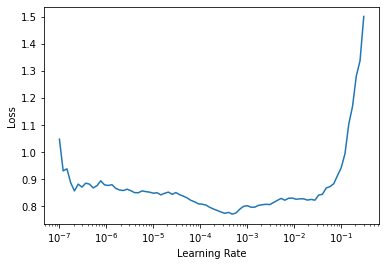

In [17]:
learn.lr_find()

In [18]:
learn.fit_one_cycle(40,3e-5)

epoch,train_loss,valid_loss,f1_tsh,acc_tsh,rcl_tsh,time
0,0.841634,0.746839,0.370964,0.450382,0.325700,00:14
1,0.791358,0.741165,0.379475,0.427481,0.372519,00:14
2,0.778185,0.728374,0.542150,0.549618,0.600509,00:13
3,0.744086,0.763622,0.441946,0.496183,0.437659,00:14
4,0.709101,0.804005,0.450523,0.496183,0.439695,00:13
5,0.659809,0.887095,0.484022,0.442748,0.549618,00:14
6,0.615027,0.862220,0.416068,0.503817,0.390840,00:14
7,0.562397,1.113312,0.385367,0.358779,0.380662,00:14
8,0.511718,1.232334,0.387932,0.450382,0.370483,00:14
9,0.466218,1.334258,0.273168,0.396947,0.215776,00:14


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


# T3 single model

In [15]:
loss_func = Loss_multi_head(1)

In [16]:
learn = Learner(dls,model,loss_func=loss_func,metrics=[f1_t3,acc_t3,rcl_t3])

SuggestedLRs(lr_min=3.311311302240938e-05, lr_steep=1.9054607491852948e-06)

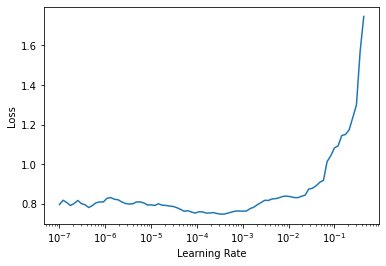

In [17]:
learn.lr_find()

In [18]:
learn.fit_one_cycle(40,3e-5)

epoch,train_loss,valid_loss,f1_t3,acc_t3,rcl_t3,time
0,0.832312,0.732911,0.112900,0.503817,0.064352,00:14
1,0.830242,0.671201,0.408019,0.519084,0.362472,00:14
2,0.797773,0.671438,0.490647,0.519084,0.492490,00:14
3,0.749422,0.699341,0.487946,0.519084,0.500369,00:14
4,0.716639,0.749628,0.514957,0.549618,0.544365,00:14
5,0.690800,0.745011,0.456024,0.549618,0.426824,00:14
6,0.640573,0.836025,0.457743,0.557252,0.398588,00:13
7,0.594865,0.874984,0.584804,0.595420,0.649430,00:14
8,0.546953,0.942111,0.480263,0.549618,0.464253,00:14
9,0.498978,0.994475,0.609732,0.587786,0.749897,00:13


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# T4 single model

In [15]:
loss_func = Loss_multi_head(2)

In [16]:
learn = Learner(dls,model,loss_func=loss_func,metrics=[f1_t4,acc_t4,rcl_t4])

SuggestedLRs(lr_min=2.7542287716642023e-05, lr_steep=7.585775847473997e-07)

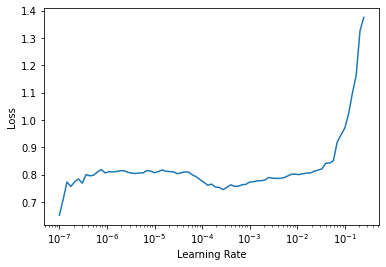

In [17]:
learn.lr_find()

In [18]:
learn.fit_one_cycle(40,3e-5)

epoch,train_loss,valid_loss,f1_t4,acc_t4,rcl_t4,time
0,0.849688,0.759976,0.439228,0.473282,0.467176,00:14
1,0.828616,0.770192,0.256999,0.412214,0.234097,00:14
2,0.796277,0.786066,0.387350,0.435115,0.404071,00:14
3,0.731910,0.779633,0.462747,0.503817,0.470229,00:14
4,0.691535,0.796328,0.410193,0.488550,0.380662,00:14
5,0.647915,0.840169,0.390113,0.435115,0.397964,00:14
6,0.597438,0.792184,0.397374,0.519084,0.356234,00:14
7,0.541025,0.975936,0.439620,0.534351,0.417303,00:14
8,0.507855,1.082992,0.500424,0.511450,0.544529,00:14
9,0.446996,1.185260,0.448891,0.519084,0.423410,00:14


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Fin